# Problem Set 3

In this exercise, use the 311 dataset.

You also need to read back the PLUTO dataset from Cloud Object Store that you saved previously in the course. Use the PLUTO dataset for the borough that you already identified to focus on the last exercise.Ensure that you use only a limited number of fields from the dataset so that you are not consuming too much memory during your analysis.

The recommended fields are Address, BldgArea, BldgDepth, BuiltFAR, CommFAR, FacilFAR, Lot, LotArea, LotDepth, NumBldgs, NumFloors, OfficeArea, ResArea, ResidFAR, RetailArea, YearBuilt, YearAlter1, ZipCode, YCoord, and XCoord.

At the end of this exercise, you should determine whether the type of complaint that you have identified as the response to Question 1 has an obvious relationship with any particular characteristic or characteristics of the houses.

In [1]:
## Import important packages and set up notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.style.use('ggplot')
import matplotlib.cm as cm
import seaborn as sns

import pandas as pd
import pandas_profiling
import numpy as np
from numpy import percentile
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p

import os, sys
import calendar
import matplotlib.pyplot as plt


## Some default plot settings
plt.rc('font', size=18)        
plt.rc('axes', titlesize=22)      
plt.rc('axes', labelsize=18)      
plt.rc('xtick', labelsize=12)     
plt.rc('ytick', labelsize=12)     
plt.rc('legend', fontsize=12)   

local = True
if (local):
    BASE_PATH = "../"

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_311 = pd.read_csv(f"{BASE_PATH}nyc311.csv",index_col='unique_key')
df_PLUTO = pd.read_csv(f"{BASE_PATH}BX_18v1.csv")


In [3]:
df_PLUTO = df_PLUTO[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 
                     'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 
                     'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1', 'ZipCode', 'YCoord','XCoord']]
df_PLUTO['ZipCode'].fillna(0,inplace=True)
df_PLUTO['ZipCode'] = df_PLUTO['ZipCode'].astype(int)

### Splice out the parts of the 311 data frame we want and drop columns without a zip

In [4]:
df = df_311[((df_311['complaint_type'] == 'HEAT/HOT WATER') | (df_311['complaint_type'] == 'HEATING'))]
df = df.dropna(subset=['incident_zip'])
df['incident_zip'] = df['incident_zip'].astype(int)

## We will drop rows we know are not the Bronx, clean up unkown rows, then drop anything which is not the Bronx

In [5]:
## Need to correct some of the 'Unspecified'
def borough_fix(city,zip_code):
    ### 1rst check if the borough is listed as the city
    bor_list = ['BRONX','BROOKLYN','MANHATTEN','QUEENS','STATEN ISLAND']
    brooklyn_zip = [11212, 11213, 11216, 11233, 11238,11209, 11214, 11228,
                  11204, 11218, 11219, 11230,
                  11234, 11236, 11239,
                  11223, 11224, 11229, 11235,
                  11201, 11205, 11215, 11217, 11231,
                  11203, 11210, 11225, 11226,
                  11207, 11208, 11211, 11222,
                  11220, 11232, 11206, 11221, 11237]
    queens_zip = [
        11361, 11362, 11363, 11364, 11354, 11355, 11356, 11357, 11358, 11359, 11360,
        11365, 11366, 11367, 11412, 11423, 11432, 11433, 11434, 11435, 11436,
        11101, 11102, 11103, 11104, 11105, 11106, 11374, 11375, 11379, 11385,
        11691, 11692, 11693, 11694, 11695, 11697, 11004, 11005, 11411, 11413, 
        11422, 11426, 11427, 11428, 11429, 11414, 11415, 11416, 11417, 11418, 
        11419, 11420, 11421, 11368, 11369, 11370, 11372, 11373, 11377, 11378
    ]
    
    if city in bor_list:
        return city
    
    ### If not check the zipcode and match with borough
    # zipcodes from https://www.quora.com/What-is-the-ZIP-code-numbering-plan-for-New-York-City
    # https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm
    if zip_code in range(10000,10199):
        return 'MANHATTEN'
    if zip_code in range(10300,10400):
        return 'STATEN ISLAND'
    if zip_code in range(10400,10500):
        return 'BRONX'
    if zip_code in brooklyn_zip:
        return 'BROOKLYN'
    if zip_code in queens_zip:
        return 'QUEENS'
    else:
        return 'Unspecified'
## Drop Boroughs which are not Bronx    
df = df[((df['borough']=='BRONX') | (df['borough']== 'Unspecified'))]
df['borough'] = df.apply(lambda x: borough_fix(x['city'],x['incident_zip']) if (x['borough'] == 'Unspecified') 
                         else x['borough'] ,axis=1)
df = df[df['borough']=='BRONX']
df_311 = df[['incident_zip','incident_address','street_name','latitude','longitude']]

### We will now make sure to strip off any excess spaces from address columns in the two data frames and merge them.

In [6]:
def strip_and_clean(df,col):
    df[col] = df[col].str.strip()
    df[col] = (df[col].str.split()).str.join(' ')
    return df
        
df_311['incident_address'] = df_311['incident_address'].str.strip()
df_311['incident_address'] = (df_311['incident_address'].str.split()).str.join(' ')
df_311.rename(columns={'incident_address':'Address'},inplace=True)

df_PLUTO['Address'] = df_PLUTO['Address'].str.strip()
df_PLUTO['Address'] = (df_PLUTO['Address'].str.split()).str.join(' ')

df_PLUTO['Street'] = df_PLUTO['Address'].str.replace('^[^a-zA-Z]+', '')
df_PLUTO['Street'] = df_PLUTO['Street'].str.strip()
df_PLUTO['Street'] = df_PLUTO['Street'].str.replace('^[a-zA-Z]\s', '')
df_PLUTO['Street'] = (df_PLUTO['Street'].str.split()).str.join(' ')
df_PLUTO['Street'] = df_PLUTO['Street'].str.strip()

## Create a column in the PLUTO data frame indicating whether a Address had a report or now

In [7]:
def address_finder(address,incident_addresses):
    if (address in incident_addresses):
        return 1
    else:
        return 0


In [8]:
incident_addresses = df_311['Address'].unique()
df_PLUTO['complaint'] = df_PLUTO.apply(lambda x: address_finder(x['Address'],incident_addresses),axis=1)
#df_merged = pd.merge(df_311, df_PLUTO, on='Address', how='left')


# Clean the dataset 

# What each column uses as as unknown values
   - BldgArea: 0 means not available if NumBldgs != 0, else does not apply
      - We will replace with street mean if NumBldgs != 0 else 0
   - BldgDepth, BuiltFAR, : 
      - 0 will be replaced with street mean as long as num building != 0 else 0
   - FacilFAR:
      - 0 will be replaced with street mean   
   - Lot is tax lot so no blanks
   - LotArea: If the LOT AREA is zero, data is not available for the tax lot. 
      - Replace with street avg
   - LotDepth: 
      - Replace with street avg
   - NumBldgs: 0 is an acceptable value will not be replaced
   - NumFloors:
     - 0 will be replaced with street mean as long as num building != 0 else 0
   - OfficeArea: An OFFICE FLOOR AREA of zero can mean it is either not available or not applicable.
     - No replacement will be done
   - ResArea: A RESIDENTIAL FLOOR AREA of zero can mean it is either not available or not applicable
     - No replacement will be done
   - RetailArea: A RETAIL FLOOR AREA of zero can mean it is either not available or not applicable.
     - No replacement will be done
   - YearBuilt: 
     - Replace with street mode
   - YearAlter1:
     - Zero means no alteration so replace with YearBuilt
   - ZipCode
     - replace 0 with street mode
   
    
   
      
   
   
   

In [9]:
def missing_data(df):
    missing = [(c, df[c].isna().mean()*100) for c in df]
    missing = pd.DataFrame(missing, columns=["column_name", "percentage"])
    missing = missing[missing.percentage > 0]
    display(missing.sort_values("percentage", ascending=False))
    
    
def fill_by_street_mean(df,col):
    mean_by_street = df.groupby('Street')[col].mean()
    df[col] = df.groupby('Street')[col].apply(lambda x: x.fillna(mean_by_street[x.name]))
    return df
  

### Since we are working off of address having no address will not work so we will drop all rows with NaN in address field

In [10]:
df_PLUTO = df_PLUTO.dropna(subset=['Address','Street'])

#### This part could be rewritten to be more efficient by using a single function which does all these replacements. Currently it is looping way more than needed

In [11]:
replace_list = ['BldgArea','BldgDepth','BuiltFAR','NumFloors']
replace_list_all = ['FacilFAR','LotArea','LotDepth']


means = df_PLUTO.groupby('Street').mean()
modes = df_PLUTO[['YearBuilt','ZipCode']].mode()

def replacer(x):
    street = x['Street']
    if(x['NumBldgs']!=0):
        for col in replace_list:
             if (x[col] == 0):
                x[col] = means.ix[street,col]
    else:
        for col in replace_list_all:
             if (x[col] == 0):
                x[col] = means.ix[street,col]  
                
    if (x['YearBuilt'] == 0):
        x['YearBuilt'] = modes['YearBuilt'][0]
        
    if (x['YearAlter1'] == 0):
        x['YearAlter1'] = x['YearBuilt']
        
    if (x['ZipCode'] == 0):
        x['ZipCode'] = modes['ZipCode'][0]
        
    return x 



In [12]:
df_PLUTO = fill_by_street_mean(df_PLUTO,'XCoord')
df_PLUTO = fill_by_street_mean(df_PLUTO,'YCoord')
df_PLUTO = df_PLUTO.dropna(subset=['YCoord','XCoord'])


df_PLUTO = df_PLUTO.apply(lambda x: replacer(x),axis = 1)


#df_PLUTO.head()


## Drop the 1% of data here which has no same street buildings

### We will not define some plotting functions to more easily analyse the corrilations

In [13]:
# Variable corrilation
def show_corrilations(df):
    corr = df.select_dtypes(include="number").corr()
    plt.subplots(figsize=(8,8));
    sns.heatmap(corr, cmap="RdBu", square=True, cbar_kws={"shrink": .7})
    plt.title("Correlation matrix of all numerical features\n")
    plt.tight_layout()
    plt.show()

# Variable corrilation with survived    
def corr_with_complaint(df):
    corr = df.select_dtypes(include="number").corr()
    plt.figure(figsize=(8,8));
    corr["complaint"].sort_values(ascending=True)[:-1].plot(kind="barh")
    plt.title("Correlation of numerical feature to Complaint at Address")
    plt.xlabel("Correlation to Complaint")
    plt.tight_layout()
    plt.show()

# Feature Engineering
   - Age of building
   - Binned tax lot: 
      - [1-999]:Traditional, 
      - [1001-6999]:Condominium Unit
      - [7501,7599]: Condominium Billing
      - [8000-8899]: Subterranean
      - [8900-8999]: DTM Dummy 
      - [9000-9899]: Air Rights
      - else : unknown

In [14]:
df_PLUTO['Age'] = 2019 - df_PLUTO['YearBuilt']
df_PLUTO['Age_of_Alt'] = 2019 - df_PLUTO['YearAlter1']

def taxer(x):
    tax_id = x['Lot']
    if (tax_id in range(1,1000)):
        return 'Traditional'
    
    elif (tax_id in range(1000,7000)):
        return 'Condo Unit'
    
    elif (tax_id in range(7501,7600)):
        return 'Condo Bill'
    
    elif (tax_id in range(8000,8900)):
        return 'Subterranean'
    
    elif (tax_id in range(8900,9000)):
        return 'DTM Dummy'
    
    elif (tax_id in range(9000,9900)):
        return 'Air Right'
    
    else:
        return 'Unknown'
        

df_PLUTO['Tax_type'] = df_PLUTO.apply(lambda x: taxer(x), axis = 1)

## We will now one hot the catagorical

In [15]:
def onehot_encode(df,columns):
    #df_numeric = df.select_dtypes(exclude=['object'])
    df_obj = df[columns].copy()

    cols = []
    for c in df_obj:
        dummies = pd.get_dummies(df_obj[c])
        dummies.columns = [c + "_" + str(x) for x in dummies.columns]
        cols.append(dummies)
    df_obj = pd.concat(cols, axis=1)

    df = pd.concat([df, df_obj], axis=1)
    df.reset_index(inplace=True, drop=True)
    return df  

def drop_catagotical(df):
    catagorical_cols = [col for col in df.columns if df[col].dtype == "object"]
    df = df.drop(catagorical_cols,axis=1)
    return df

def catboost_encode(df,columns):
    import category_encoders as ce
    
#    df_train = pd.read_csv(f"{BASE_PATH}train.csv",index_col='PassengerId')
#    df_test = pd.read_csv(f"{BASE_PATH}test.csv",index_col='PassengerId')
#    df_total = pd.concat([df_train, df_test]).copy()
    
      
#    df_total = totally_cleaned(df_total)
#    df_total = feature_engineering(df_total)
    cb_enc = ce.CatBoostEncoder(cols=columns)
    count_encoded = cb_enc.fit(df[columns],df['complaint'])
    df = df.join(cb_enc.transform(df[columns]).add_suffix('_cb'))
    return df

In [16]:
to_hot = ['Tax_type']

df_PLUTO = onehot_encode(df_PLUTO,to_hot)
df_PLUTO_2 = catboost_encode(df_PLUTO,'Street')


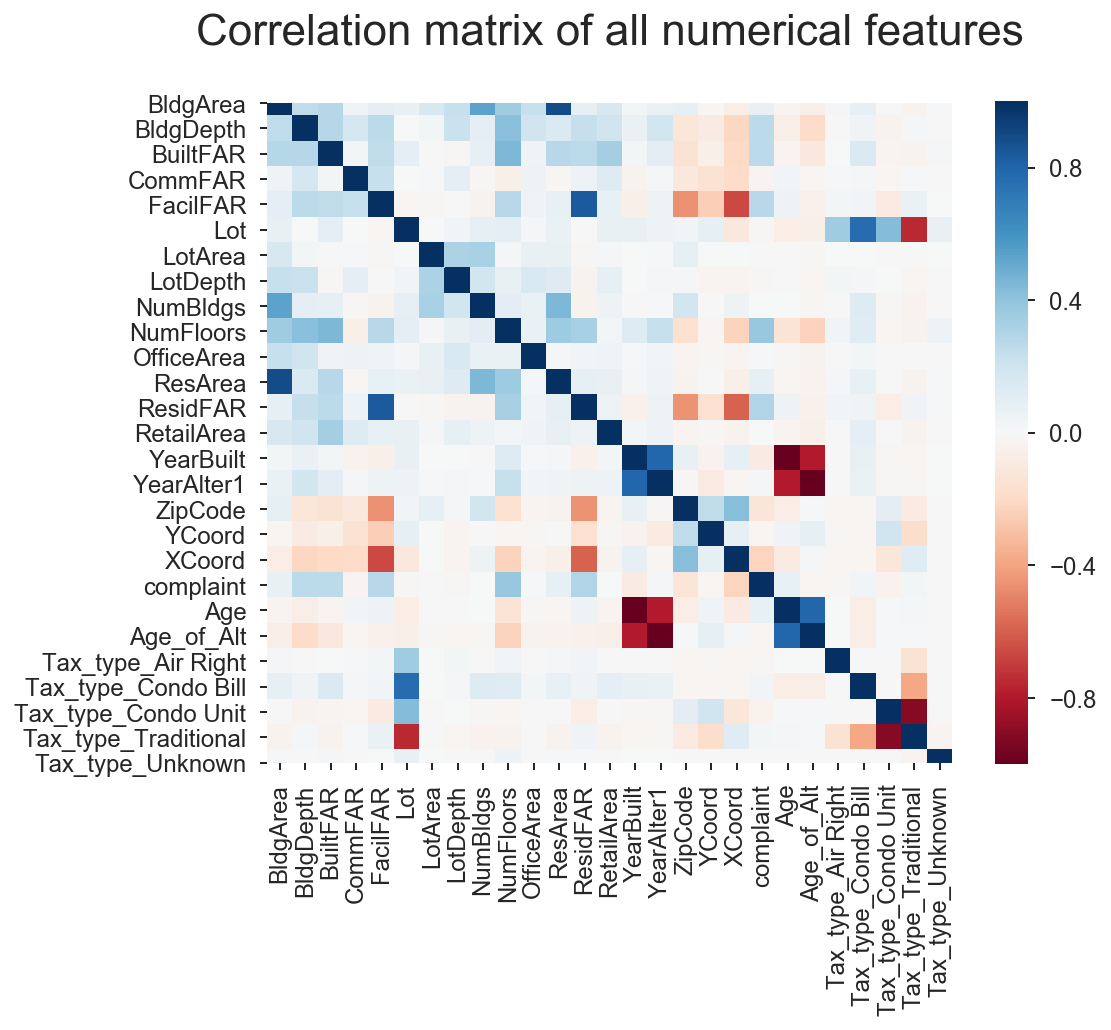

In [17]:
show_corrilations(df_PLUTO)

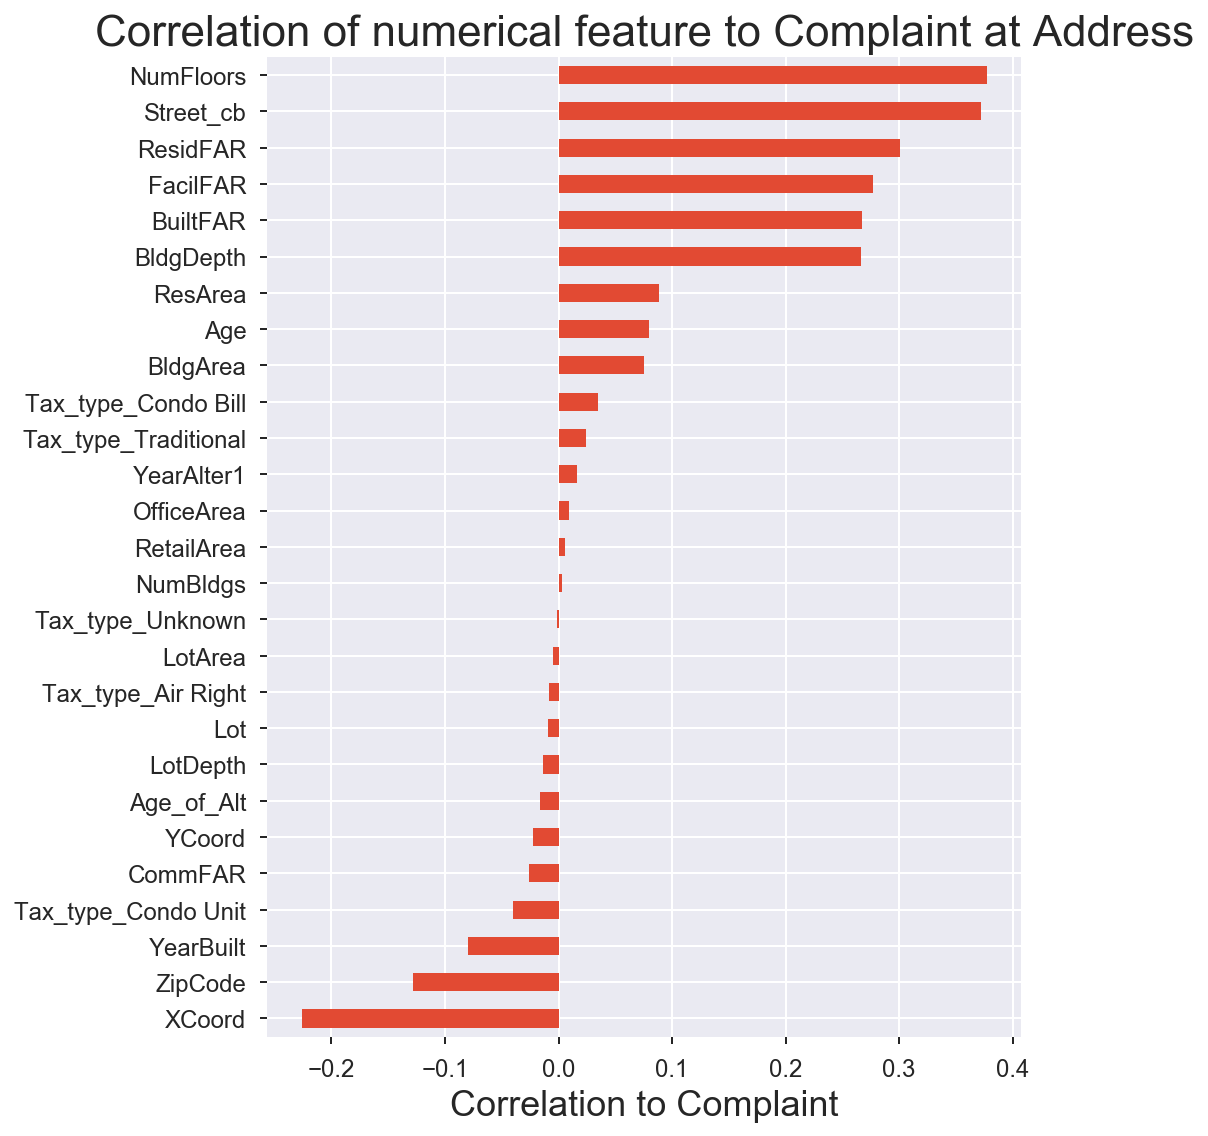

In [18]:
corr_with_complaint(df_PLUTO_2)

## Question: Does the Complaint Type that you identified in response to Question 1 have an obvious relationship with any particular characteristic or characteristic of the Houses?

### Answer: Yes, The Number of Floors is coorilated with the complaint. I also Catagorical Boost encoded the street name which is corrilated with complaint. Other characteristics with high positive or negative corrilations are ResidFAR, FacilFAR, BuiltFAR, Age, Year Built, ZipCode, and XCoord as can be seen in the plot in my notebook.